In [1]:
import mlflow
import mlflow.keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping
from plot_keras_history import show_history
from mlflow.models import infer_signature

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Start MLFlow tracking
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Experiments")

<Experiment: artifact_location='mlflow-artifacts:/474867125159941001', creation_time=1716084706310, experiment_id='474867125159941001', last_update_time=1716084706310, lifecycle_stage='active', name='Experiments', tags={}>

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Load the dataset
data = pd.read_csv('preprocessed_laptop_data.csv')

# Separate features and target variable
X = data.drop(columns=['Price'])
y = data['Price']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Convert the data to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape, 'train input samples')
print(x_test.shape, 'test input samples')
print(y_train.shape, 'train target samples')
print(y_test.shape, 'test target samples')

(3184, 9) train input samples
(796, 9) test input samples
(3184,) train target samples
(796,) test target samples


In [5]:
# Basic neural network
def basic_model(epochs):
    model = Sequential()
    model.add(layers.Dense(20, activation='sigmoid', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(20, activation='sigmoid'))
    model.add(layers.Dense(1))  # Single output for regression
    model.summary()
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))
    loss, mse = model.evaluate(x_test, y_test, verbose=0)
    model_name = "basic_model"
    
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("epochs", epochs)
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("mse", mse)
    mlflow.keras.log_model(model, "models")
    
    return history

num_epochs = 500:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                200       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
100/100 [==============================] - 1s 3ms/step - loss: 327909.0938 - mse: 327909.0938 - val_loss: 327181.7188 - val_mse: 327181.7188
Epoch 2/500
100/100 [==============================] - 0s 2ms/step - loss: 324980.7188 - mse: 324980.7188 - val_loss:

2024/05/19 11:01:26 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmp6akrc3xd\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmp6akrc3xd\model\data\model\assets
2024/05/19 11:01:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ramesh\AppData\Local\Temp\tmp6akrc3xd\model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


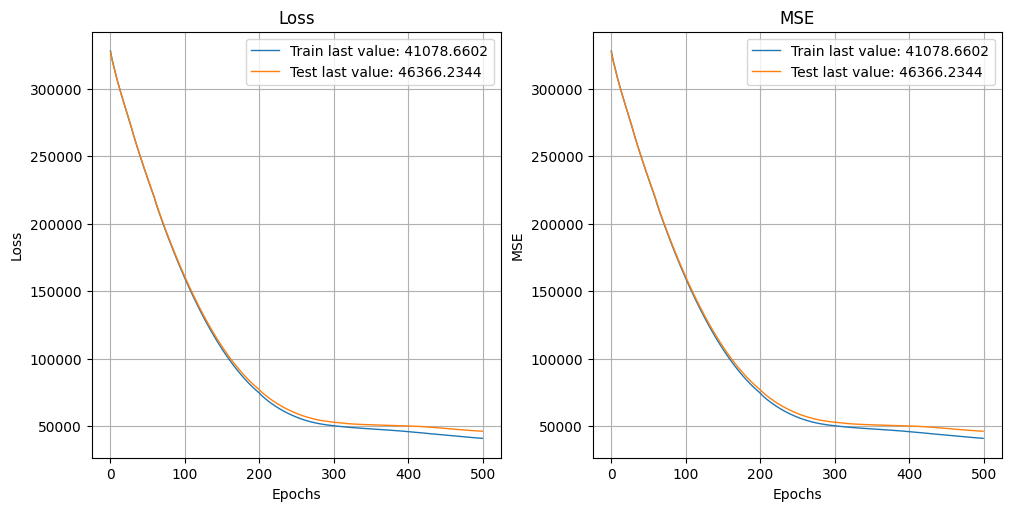

-----------------------------------------------------------------------------------------------------------------------------
num_epochs = 1000:
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 20)                200       
                                                                 
 dense_7 (Dense)             (None, 20)                420       
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
100/100 [==============================] - 1s 4ms/step - loss: 329745.8750 - mse: 329745.8750 - val_loss: 329192.1875 - val_mse: 3

2024/05/19 11:05:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmp0nwxygxg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmp0nwxygxg\model\data\model\assets
2024/05/19 11:05:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ramesh\AppData\Local\Temp\tmp0nwxygxg\model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


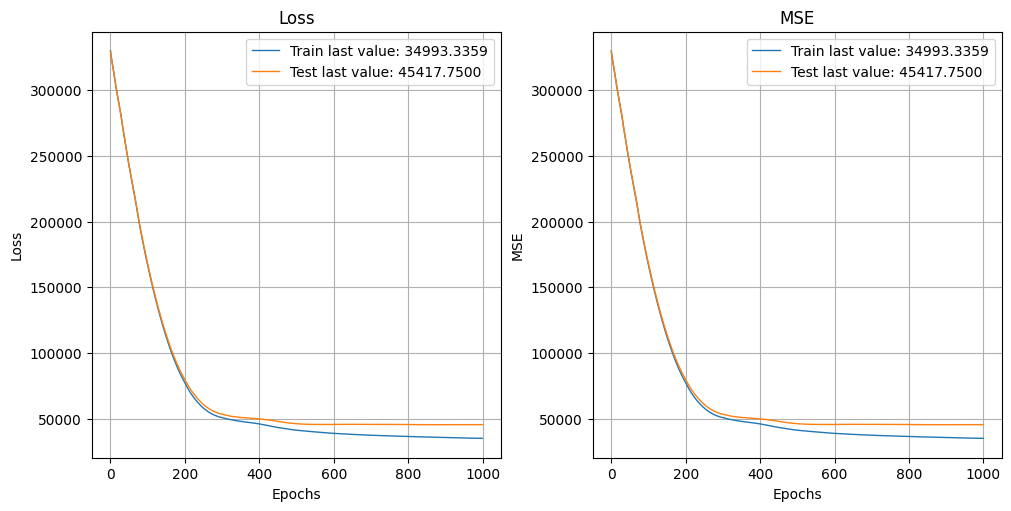

-----------------------------------------------------------------------------------------------------------------------------


In [7]:
with mlflow.start_run(run_name = "Basic_NN", nested = True):
    # Varying num_epochs
    with mlflow.start_run(run_name = "Expt_1", nested = True):
        print("num_epochs = 500:")
        show_history(basic_model(500))
        print('-' * 125)
    with mlflow.start_run(run_name = "Expt_2", nested = True):
        print("num_epochs = 1000:")
        show_history(basic_model(1000))
        print('-' * 125)

In [8]:
import tensorflow as tf

# Better neural network
def better_model(epochs):
    model = Sequential()
    model.add(layers.Dense(20, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1))  # Single output for regression
    model.summary()

    # Set the learning rate for the Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test))
    loss, mse = model.evaluate(x_test, y_test, verbose=0)
    model_name = "basic_model"
    
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("epochs", epochs)
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("mse", mse)
    mlflow.keras.log_model(model, "models")
    
    return history

num_epochs = 250:
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 20)                200       
                                                                 
 dense_10 (Dense)            (None, 20)                420       
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/250
100/100 [==============================] - 1s 4ms/step - loss: 328563.6250 - mse: 328563.6250 - val_loss: 326234.5000 - val_mse: 326234.5000
Epoch 2/250
100/100 [==============================] - 0s 2ms/step - loss: 317290.8438 - mse: 317290.8438 - val_loss:

2024/05/19 11:07:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmppj5xytdi\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmppj5xytdi\model\data\model\assets
2024/05/19 11:07:31 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ramesh\AppData\Local\Temp\tmppj5xytdi\model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


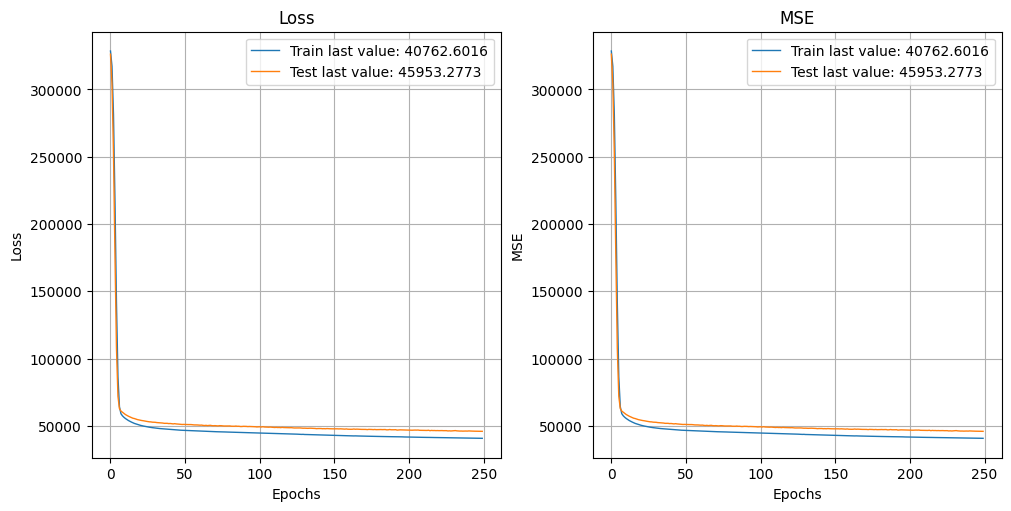

-----------------------------------------------------------------------------------------------------------------------------
num_epochs = 500:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20)                200       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 1)                 21        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
100/100 [==============================] - 1s 4ms/step - loss: 327833.8438 - mse: 327833.8438 - val_loss: 324959.2188 - val_mse: 324

2024/05/19 11:09:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmprvtd62tn\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\Ramesh\AppData\Local\Temp\tmprvtd62tn\model\data\model\assets
2024/05/19 11:09:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ramesh\AppData\Local\Temp\tmprvtd62tn\model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


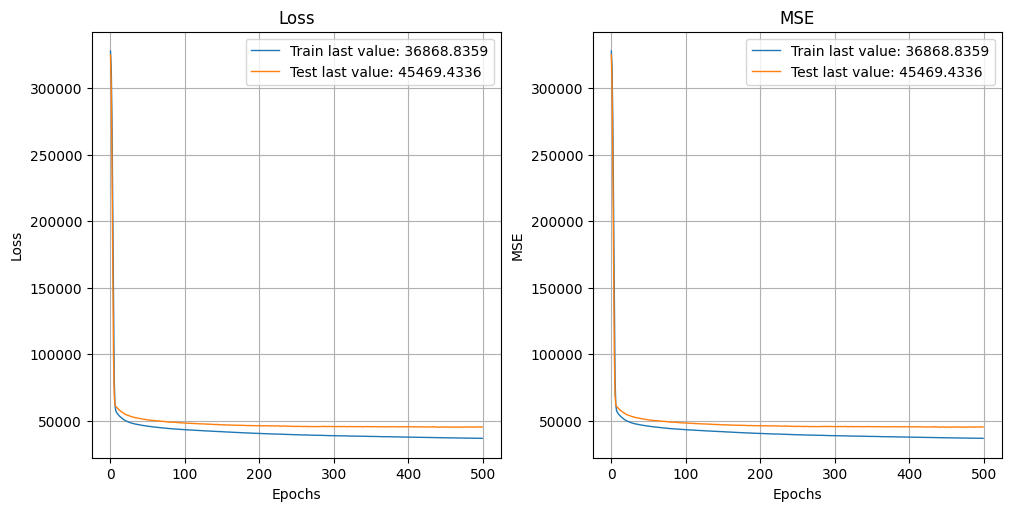

-----------------------------------------------------------------------------------------------------------------------------


In [9]:
with mlflow.start_run(run_name = "Better_NN", nested = True):
    # Varying num_epochs
    with mlflow.start_run(run_name = "Expt_1", nested = True):
        print("num_epochs = 250:")
        show_history(better_model(250))
        print('-' * 125)
    with mlflow.start_run(run_name = "Expt_2", nested = True):
        print("num_epochs = 500:")
        show_history(better_model(500))
        print('-' * 125)

In [14]:
from sklearn import svm
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score, KFold


kf = KFold(n_splits=5, shuffle=True, random_state=42)

C_values = [1.0, 10.0, 100.0, 1e3]

for C in C_values:
    # Train an SVM model
    with mlflow.start_run(run_name='SVM', nested=True):

        
        # Define model parameters
        mlflow.log_param("C", C)
        mlflow.log_param("kernel", "rbf")

        # Train the SVM model
        model = svm.SVR(C=C, kernel='rbf')
        scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        mse_scores = -scores
        mean_mse = np.mean(mse_scores)

        # Log metrics
        mlflow.log_metric("train_loss", mean_mse)

        # Log the model
        mlflow.sklearn.log_model(model, "svm_model")

    print(f"Train Loss: {mean_mse}")

2024/05/19 11:15:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ramesh\AppData\Local\Temp\tmp6cma81s1\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


Train Loss: 52052.97388630711


2024/05/19 11:15:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ramesh\AppData\Local\Temp\tmpy61ti7kv\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


Train Loss: 44964.56121317904


2024/05/19 11:15:30 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\Ramesh\AppData\Local\Temp\tmp53438k2j\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.3.1', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 


Train Loss: 41672.094497208454
Train Loss: 42645.42732877311
